In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os
import sys
import glob as gb
import re
from pathlib import Path
from itertools import repeat

import numpy as np
import pandas as pd



from PIL import Image

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale

from mlxtend.preprocessing import minmax_scaling


import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
import matplotlib.image as mpimg
from matplotlib import cm
mpl.style.use('classic')

import pydicom as dcm
import pylab

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets


from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

from pathlib import Path
import json
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True


import getpass
import os

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(True)

#import ipdb; ipdb.set_trace()

In [16]:
# Pathes
HOME = Path.home()

RAW = HOME / 'data/OriginalsAneurysm'

AUTO512 = RAW / '512Auto'
STL = RAW / 'stls.bk'

DATA = HOME / 'data/aneurysm'
PATH = DATA

CT_DCM = DATA / 'ct-512'
MASK_DCM = DATA / 'mask-512'

CT_DCM =DATA / 'ct-512' 

CT_NP = DATA / 'ct-512-NP'
MASK_NP = DATA / 'mask-512-NP'

CT_PNG = DATA / 'ct-512-PNG'
MASK_PNG = DATA / 'mask-512-PNG'

# CT_128 = DATA / 'train-128'
# MASK_128 = DATA / 'train_masks-128'

# CT_128_NP = DATA / 'ct-128-NP'
# MASK_128_NP = DATA / 'mask-128-NP'

TMP = DATA / 'tmp'

CT_NP.mkdir(exist_ok=True)
MASK_NP.mkdir(exist_ok=True)

CT_PNG.mkdir(exist_ok=True)
MASK_PNG.mkdir(exist_ok=True)


In [3]:
def dicom_shape(path):
    name = path.stem
    pixel_array = dcm.read_file(str(path)).pixel_array
    return name,np.shape(pixel_array),pixel_array

def first_nonempty_slice_index(tensor):
    last = np.shape(tensor)[0]
    for i in range(0,last):
        max_val = np.max(tensor[i])
        if max_val > 0:
            return i
        
def last_nonempty_slice_index(tensor):
    last = np.shape(tensor)[0]
    for i in range(0,last)[::-1]:
        max_val = np.max(tensor[i])
        if max_val > 0:
            return i

def clean_mask(pixel_array):
    pixel_array[pixel_array > 0] = 255
    pixel_array = pixel_array.astype(np.uint8)
    return Image.fromarray(pixel_array)

def mask_dcm_to_png(path,target_dir,size=False):
    name = path.stem
    pixel_array = dcm.read_file(str(path)).pixel_array[:-2] # remove the last to layers
    layers = np.shape(pixel_array)[0]
    if size:
        for i in range(layers):
            clean_mask(pixel_array[i]).resize(size).save(str(target_dir/f"{name}_{i}.png"))
    else:
        for i in range(layers):
            clean_mask(pixel_array[i]).save(str(target_dir/f"{name}_{i}.png"))
    print(f"{name}",end=", ")
    
def ct_dcm_to_png(path,target_dir,size=False):
    name = path.stem
    pixel_array = dcm.read_file(str(path)).pixel_array[:-2] # remove the last to layers
    layers = np.shape(pixel_array)[0]
    if size:
        for i in range(layers):
            Image.fromarray(pixel_array[i]).resize(size).save(str(target_dir/f"{name}_{i}.png"))
    else:
        for i in range(layers):
            Image.fromarray(pixel_array[i]).save(str(target_dir/f"{name}_{i}.png"))
    print(f"{name}",end=", ")
    

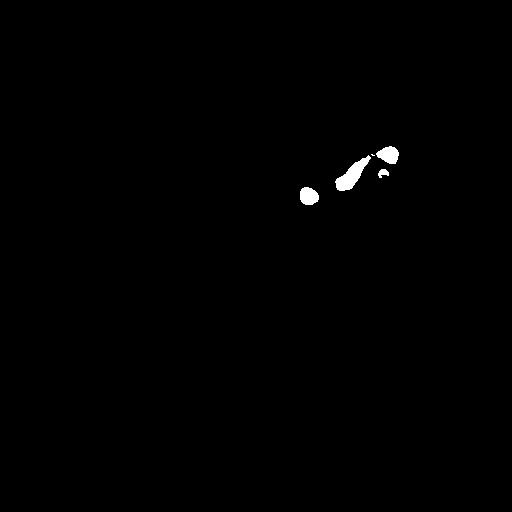

In [4]:
pixel_array = dcm.read_file(str(MASK_DCM/"A013.mask.dcm")).pixel_array
clean_mask(pixel_array[180])

In [5]:
# #np.unique(dicom_shape(mask_dcms[0])[2])
# mk = dicom_shape(mask_dcms[2])[2]
# #mk = pylab.imread(str(MASK_PNG/'A015.mask_180.png'))
# #mk = mk[:,:,:3]
# print(np.shape(mk))
# mk[mk > 0] = 255 # none zero is 255. (Binary classes)
# #print(np.unique(mk))
# mk = mk.astype(np.uint8)
# print(np.shape(mk[180]))
# #mk = np.max(mk,axis=2) # Combine all the three channels in one channel
# #pylab.imshow(mk,cmap=pylab.cm.bone)
# print(np.unique(mk))
# Image.fromarray(mk[180],mode='L')
# #plt.imshow(mk[180],cmap=pylab.cm.bone)
# #pylab.imshow(mk[180],cmap=pylab.cm.bone)
# #pylab.imshow(pylab.imread(str(MASK_PNG/'A015.mask_180.png')))

In [25]:
train_dcms = np.array(sorted(list(CT_DCM.iterdir())))
mask_dcms = np.array(sorted(list(MASK_DCM.iterdir())))
ids = [Path(x).stem for x in train_dcms]

first_mask = {}
last_mask = {}
ct_layers = {}
mask_layers = {}
mask_volume= {}

for i in range(len(train_dcms[:])):
    name, shape, tensor = dicom_shape(train_dcms[i])
    name_, shape_, tensor_ = dicom_shape(mask_dcms[i])
    first_mask[name] = first_nonempty_slice_index(tensor_)
    last_mask[name] = last_nonempty_slice_index(tensor_)
    mask_volume[name] = np.sum(tensor_)
    ct_layers[name] = shape[0]
    mask_layers[name] = shape_[0]
#     print(f"""{name}: 
#     First & Last mask indexes: {first_mask[name]},{last_mask[name]}:
#     Masks number: {last_mask[name] - first_mask[name]}
#     Original: {shape[0]}
#     Mask: {shape_[0]}""")

In [26]:
metadata = pd.DataFrame({"id":ids,
                        "first_mask": [first_mask[x] for x in ids],
                        "last_mask": [last_mask[x] for x in ids],
                        "masks_number": [last_mask[x] - first_mask[x] for x in ids],
                        "ct_layers": [ct_layers[x] for x in ids],
                        "mask_layers": [mask_layers[x] for x in ids],
                        "mask_volume": [mask_volume[x] for x in ids],
                        "ct_path":mask_dcms,
                        "mask_path":train_dcms},
                       )

metadata.sort_values("mask_volume")

,id,first_mask,last_mask,masks_number,ct_layers,mask_layers,mask_volume,ct_path,mask_path
51,A098,222,222,0,439,439,44,/home/amer/data/aneurysm/mask-512/A098.mask.dcm,/home/amer/data/aneurysm/ct-512/A098.dcm
50,A097,222,222,0,439,439,88,/home/amer/data/aneurysm/mask-512/A097.mask.dcm,/home/amer/data/aneurysm/ct-512/A097.dcm
49,A095,222,222,0,439,439,88,/home/amer/data/aneurysm/mask-512/A095.mask.dcm,/home/amer/data/aneurysm/ct-512/A095.dcm
65,PA3,222,222,0,878,878,88,/home/amer/data/aneurysm/mask-512/PA3.mask.dcm,/home/amer/data/aneurysm/ct-512/PA3.dcm
66,PA6,306,306,0,441,441,305,/home/amer/data/aneurysm/mask-512/PA6.mask.dcm,/home/amer/data/aneurysm/ct-512/PA6.dcm
60,A126,434,435,1,486,486,2048,/home/amer/data/aneurysm/mask-512/A126.mask.dcm,/home/amer/data/aneurysm/ct-512/A126.dcm
59,A123,454,456,2,493,493,2124,/home/amer/data/aneurysm/mask-512/A123.mask.dcm,/home/amer/data/aneurysm/ct-512/A123.dcm
64,A137,394,395,1,508,508,4842,/home/amer/data/aneurysm/mask-512/A137.mask.dcm,/home/amer/data/aneurysm/ct-512/A137.dcm
53,A101,23,52,29,505,505,3531313,/home/amer/data/aneurysm/mask-512/A101.mask.dcm,/home/amer/data/aneurysm/ct-512/A101.dcm
2,A015,171,216,45,439,439,36823025,/home/amer/data/aneurysm/mask-512/A015.mask.dcm,/home/amer/data/aneurysm/ct-512/A015.dcm


In [11]:
afterFilter = metadata

In [12]:
# !rm -f {TRAIN_512}/*.png
# !rm -f {MASK_512}/*.png
# !rm -f {TRAIN_128}/*.png
# !rm -f {MASK_128}/*.png
# !rm -f {TRAIN_128_3C}/*.png
# !rm -f {MASK_128_3C}/*.png

In [13]:
#!rm  {TMP}/*.npy

In [14]:
for d in DIRS:
    print(d)
    !ls -1 {d} | wc -l

NameError: name 'DIRS' is not defined

In [15]:
!ls -1 {TRAIN_512} | wc -l
!ls -1 {MASK_512} | wc -l
!ls -1 {TRAIN_128} | wc -l
!ls -1 {MASK_128} | wc -l
!ls -1 {TRAIN_128_3C} | wc -l
!ls -1 {MASK_128_3C} | wc -l

ls: cannot access '{TRAIN_512}': No such file or directory
0
ls: cannot access '{MASK_512}': No such file or directory
0
ls: cannot access '{TRAIN_128}': No such file or directory
0
ls: cannot access '{MASK_128}': No such file or directory
0
ls: cannot access '{TRAIN_128_3C}': No such file or directory
0
ls: cannot access '{MASK_128_3C}': No such file or directory
0


In [1042]:
train_dcms = np.array(sorted(list(TRAIN_DCM.iterdir())))
with ThreadPoolExecutor(6) as e: e.map(ct_dcm_to_png,train_dcms,repeat(TRAIN_512))

A016, A015, A012, A013, A018, A023, A017, A022, A025, A019, A024, A027, A032, A031, A029, A036, A033, A040, A041, A042, A043, A047, A046, A049, A057, A054, A050, A064, A051, A071, A067, A066, A072, A074, A065, A080, A077, A081, A082, A083, A075, A086, A084, A087, A088, A091, A092, A093, A100, A103, A089, A107, A109, 

In [1036]:
mask_dcms = np.array(sorted(list(MASK_DCM.iterdir())))
with ThreadPoolExecutor(6) as e: e.map(mask_dcm_to_png,mask_dcms,repeat(MASK_512))

A015.mask, A013.mask, A012.mask, A016.mask, A018.mask, A019.mask, A017.mask, A022.mask, A023.mask, A024.mask, A025.mask, A027.mask, A031.mask, A029.mask, A032.mask, A033.mask, A036.mask, A040.mask, A042.mask, A041.mask, A043.mask, A047.mask, A046.mask, A049.mask, A050.mask, A057.mask, A064.mask, A054.mask, A066.mask, A067.mask, A071.mask, A072.mask, A051.mask, A065.mask, A074.mask, A077.mask, A081.mask, A080.mask, A082.mask, A083.mask, A075.mask, A088.mask, A086.mask, A084.mask, A087.mask, A091.mask, A092.mask, A100.mask, A093.mask, A103.mask, A089.mask, A107.mask, A109.mask, 

In [1048]:
train_dcms = np.array(sorted(list(TRAIN_DCM.iterdir())))
with ThreadPoolExecutor(6) as e: e.map(ct_dcm_to_png,train_dcms,repeat(TRAIN_128),repeat((128,128)))

A016, A015, A013, A012, A018, A017, A022, A023, A019, A025, A024, A027, A032, A031, A029, A036, A033, A042, A046, A040, A047, A041, A043, A057, A054, A064, A049, A050, A071, A051, A067, A066, A072, A065, A074, A080, A081, A077, A082, A083, A075, A088, A086, A087, A084, A091, A092, A103, A100, A093, A089, A107, A109, 

In [1023]:
mask_dcms = np.array(sorted(list(MASK_DCM.iterdir())))
with ThreadPoolExecutor(6) as e: e.map(mask_dcm_to_png,mask_dcms,repeat(MASK_128),repeat((128,128)))

A015.mask, A016.mask, A012.mask, A013.mask, A018.mask, A017.mask, A022.mask, A024.mask, A023.mask, A019.mask, A025.mask, A027.mask, A033.mask, A029.mask, A032.mask, A036.mask, A031.mask, A040.mask, A047.mask, A046.mask, A042.mask, A041.mask, A043.mask, A049.mask, A064.mask, A057.mask, A050.mask, A054.mask, A051.mask, A065.mask, A071.mask, A067.mask, A066.maskA072.mask, , A074.mask, A080.mask, A081.mask, A077.mask, A082.mask, A075.mask, A083.mask, A087.mask, A088.mask, A086.mask, A084.mask, A091.mask, A092.mask, A103.mask, A089.mask, A100.mask, A093.mask, A107.mask, A109.mask, 

In [986]:
# Concatenate three (height, width)s into one (height, width, 3).
def concat_channels(r, g, b):
    #assert r.ndim == 2 and g.ndim == 2 and b.ndim == 2
    rgb = (r[..., np.newaxis], g[..., np.newaxis], b[..., np.newaxis])
    return np.concatenate(rgb, axis=-1)

def ct_dcm_to_png_3c(path,target_dir,size=False):
    name = path.stem
    layers = dcm.read_file(str(path)).pixel_array

    for i in range(len(layers)-2):
        img1 = layers[i]
        img2 = layers[i+1]
        img3 = layers[i+2]
        img = concat_channels(img1, img2, img3)
        mx, mi = img2.min(), img2.max()
        img = np.interp(img, (mx, mi), (0, 255))
        img = Image.fromarray(np.uint8(img),'RGB')
        if size:
            img.resize(size).save(str(target_dir/f"{name}_{i}.png"))
        else:
            img.save(str(target_dir/f"{name}_{i}.png"))
    print(f"{name}",end=", ")

    
# train_dcms = np.array(sorted(list(TRAIN_DCM.iterdir())))[9:10]
# for im in train_dcms:
#     print(im)
#     ct_dcm_to_png_3c(im,MASK_128,(128,128))

In [1003]:
train_dcms = np.array(sorted(list(TRAIN_DCM.iterdir())))
with ThreadPoolExecutor(6) as e: e.map(ct_dcm_to_png_3c,train_dcms,repeat(TRAIN_128_3C),repeat((128,128)))

A018, A015, A016, A012, A013, A022, A019, A024, A017, A023, A025, A027, A031, A029, A032, A033, A036, A040, A041, A042, A047, A046, A043, A050, A049, A054, A057, A064, A051, A066, A067, A071, A072, A065, A077, A074, A080, A081, A082, A083, A075, A084, A086, A087, A088, A092, A091, A093, A100, A103, A089, A107, A109, 

In [ ]:
  
            #print(f"{name}_{i} ",end="")
        #np.save(TMP/f"{name}_{i}",img)
    #depth = np.shape(pixel_array)[0]
    #new_depth = (depth - (depth%3))
    #layers = pixel_array[:new_depth] 
    #     img1 = layers[81]
#     img2 = layers[82]
#     img3 = layers[83]
    #         mx, mi = img2.min(), img2.max()  
    #img = concat_channels(img1, img2, img3)
    #img = np.interp(img, (mx, mi), (0, 1))
    #plt.imshow(img2)
    
    #imp = np.float16(img)
#     print(np.unique(img))
#     print(np.shape(img))
#     img = np.interp(img, (img.min(), img.max()), (0, 1))
    #img = np.float128(img)
#     print(np.unique(img))
    
#     #img = np.uint8(img)
#     print(np.shape(img))
#     img = np.uint8(img)#*255
#     print(np.unique(img))
    
    
    
    #Image.fromarray(img,mode="F")
    
#     plt.imshow(Image.fromarray(img))
    
    
    #return Image.fromarray(img)
    #m.save('my.png')
    #m.show()
    #print(np.shape(img1))

<ErrorbarContainer object of 3 artists>

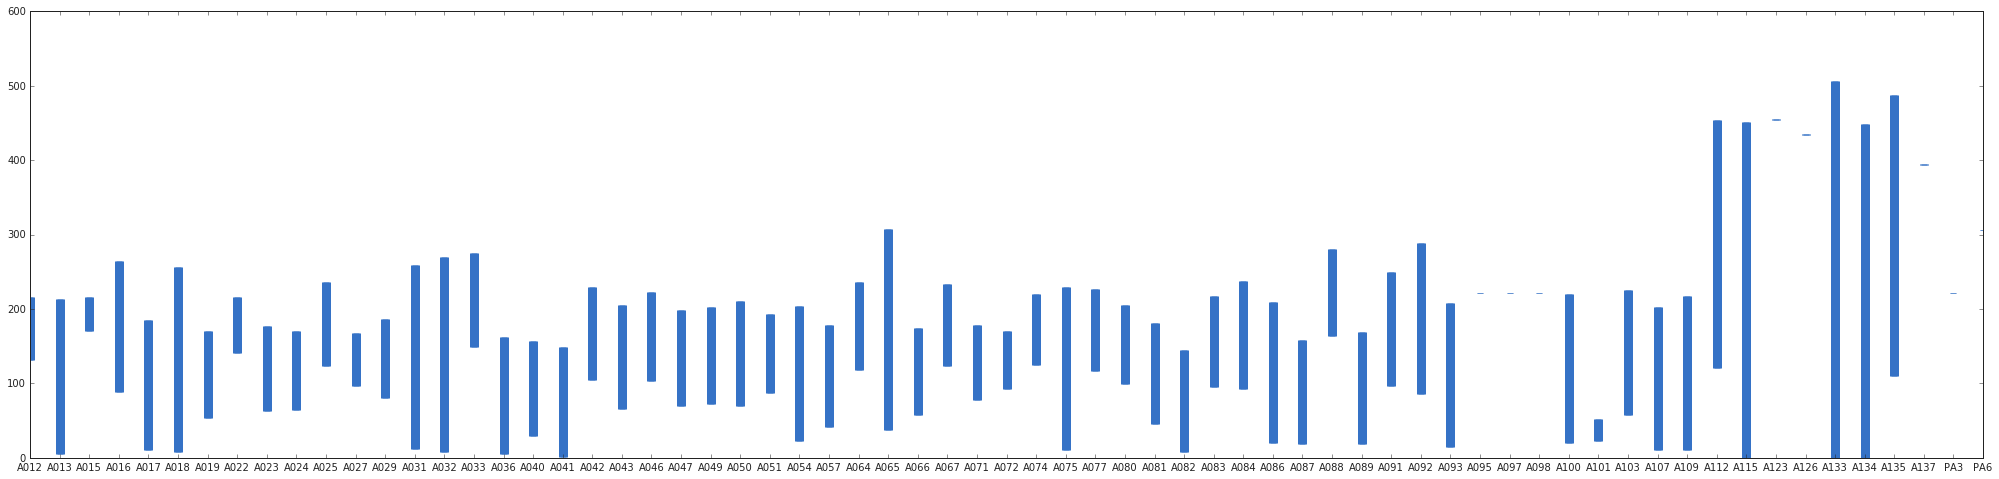

In [27]:
plt.figure(figsize=(35,8))
plt.errorbar(metadata.id, y=metadata.first_mask, yerr=[metadata.last_mask*0,metadata.last_mask-metadata.first_mask],
             linestyle='None', marker='',elinewidth=9)

<ErrorbarContainer object of 3 artists>

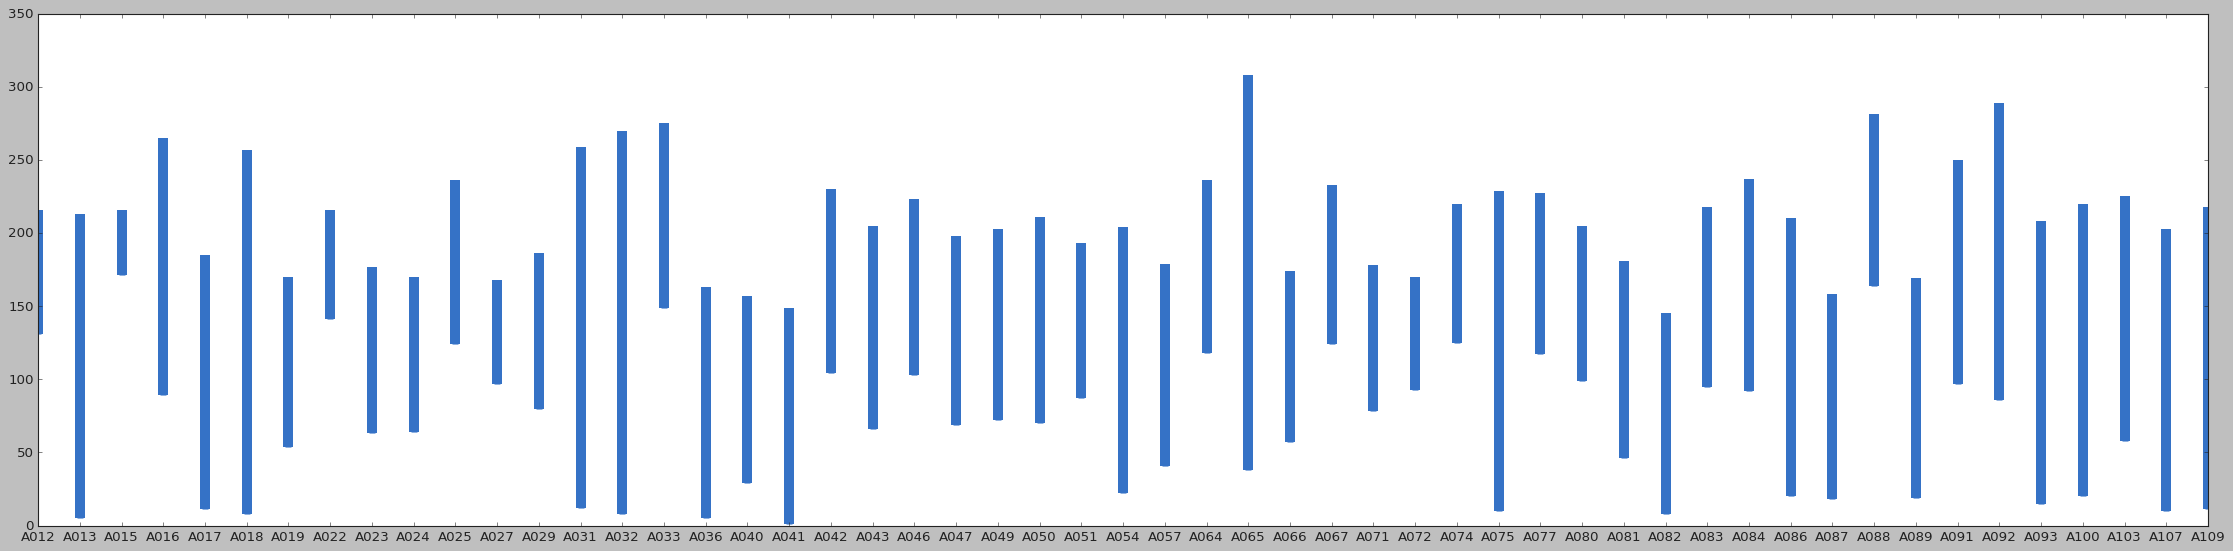

In [120]:
plt.figure(figsize=(35,8))
plt.errorbar(metadata.id, y=metadata.first_mask, yerr=[metadata.last_mask*0,metadata.last_mask-metadata.first_mask],
             linestyle='None', marker='',elinewidth=9)

In [1044]:
# Move bad Dicom images to a different folder
def move_bad_files(files):
    for f in files:
        cmd = f"mv {DATA/'ct-512'}/{f}* {DATA/'bad-ct-512'}/"
        print(cmd)
        !{cmd}
        cmd = f"mv {DATA/'mask-512'}/{f}* {DATA/'bad-mask-512'}/"
        print(cmd)
        !{cmd}

BAD_DATA = [
    "A095","A097","A098","A101","A112","A115","A123",
    "A126","A133","A134","A135","A137","PA3","PA6",]
#move_bad_files(BAD_DATA)

<BarContainer object of 67 artists>

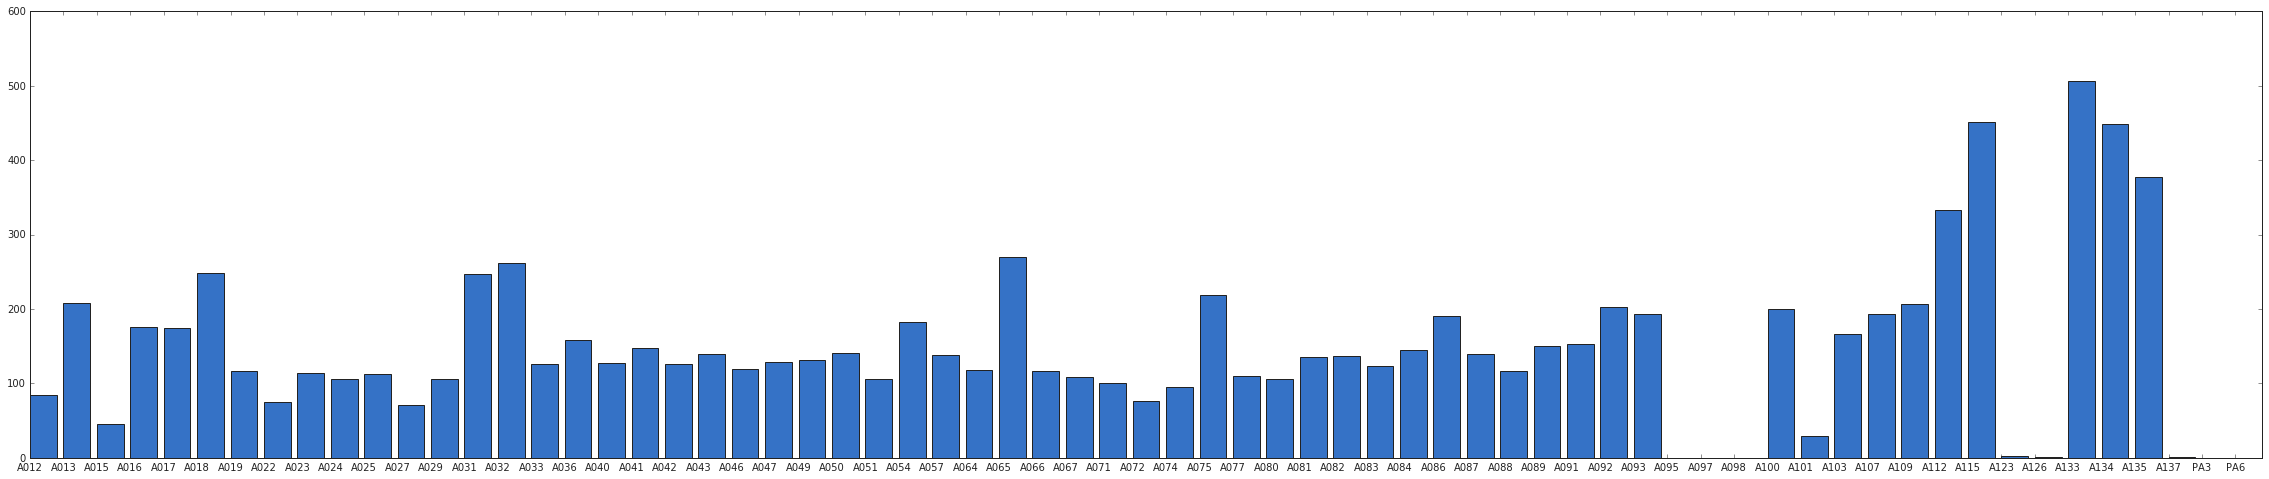

In [29]:
plt.figure(figsize=(40,8))
plt.bar(metadata.id,metadata.masks_number)

<BarContainer object of 53 artists>

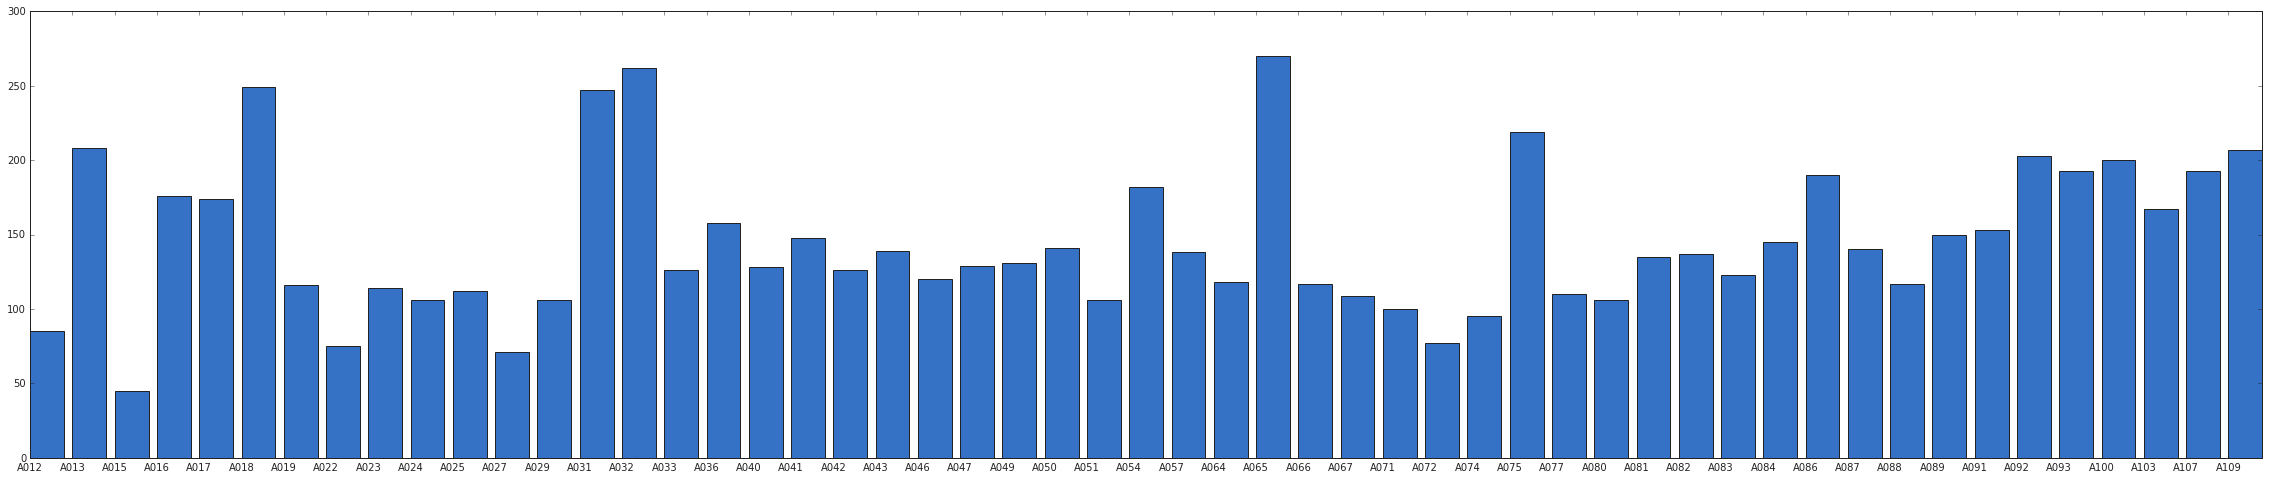

In [65]:
plt.figure(figsize=(40,8))
plt.bar(metadata.id,metadata.masks_number)

<BarContainer object of 67 artists>

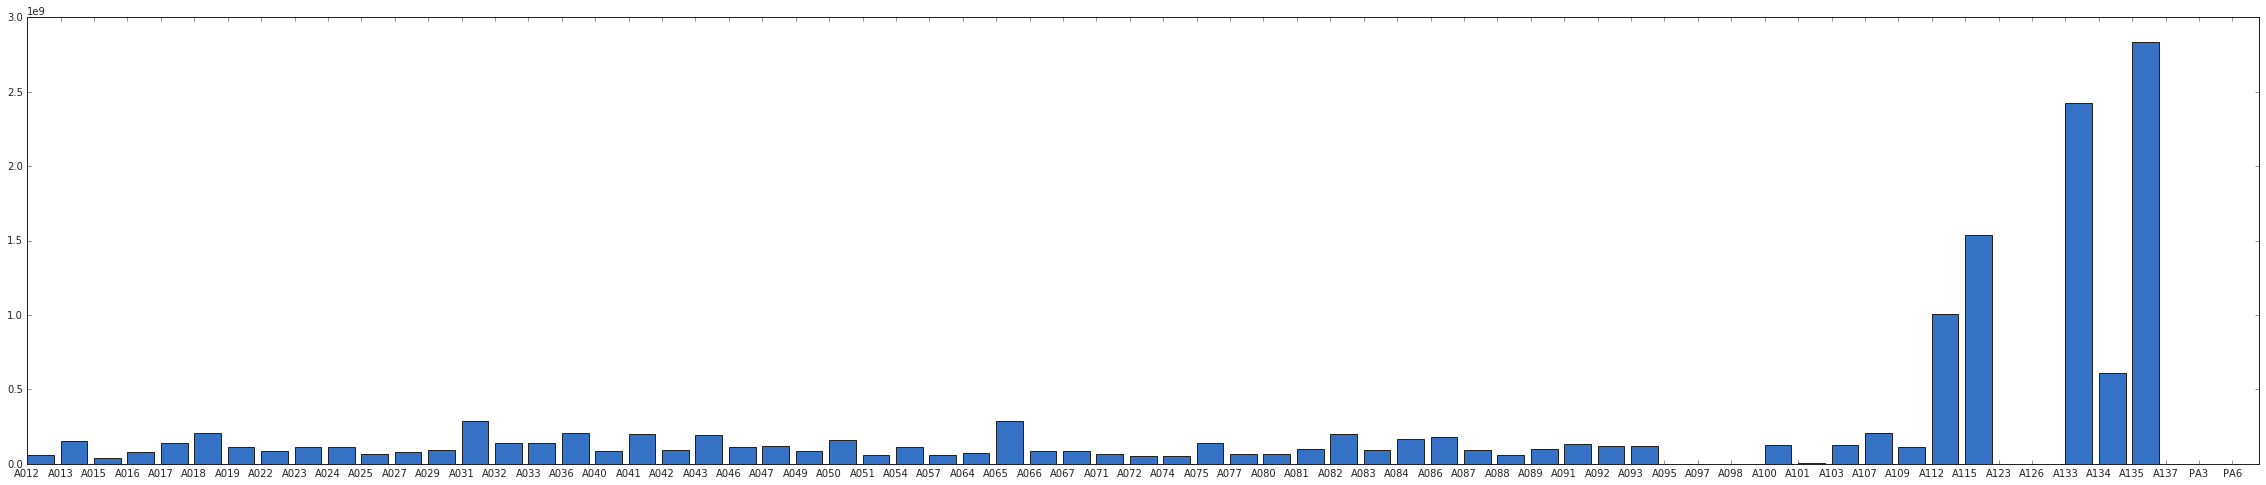

In [30]:
plt.figure(figsize=(40,8))
plt.bar(metadata.id,metadata.mask_volume)

<BarContainer object of 53 artists>

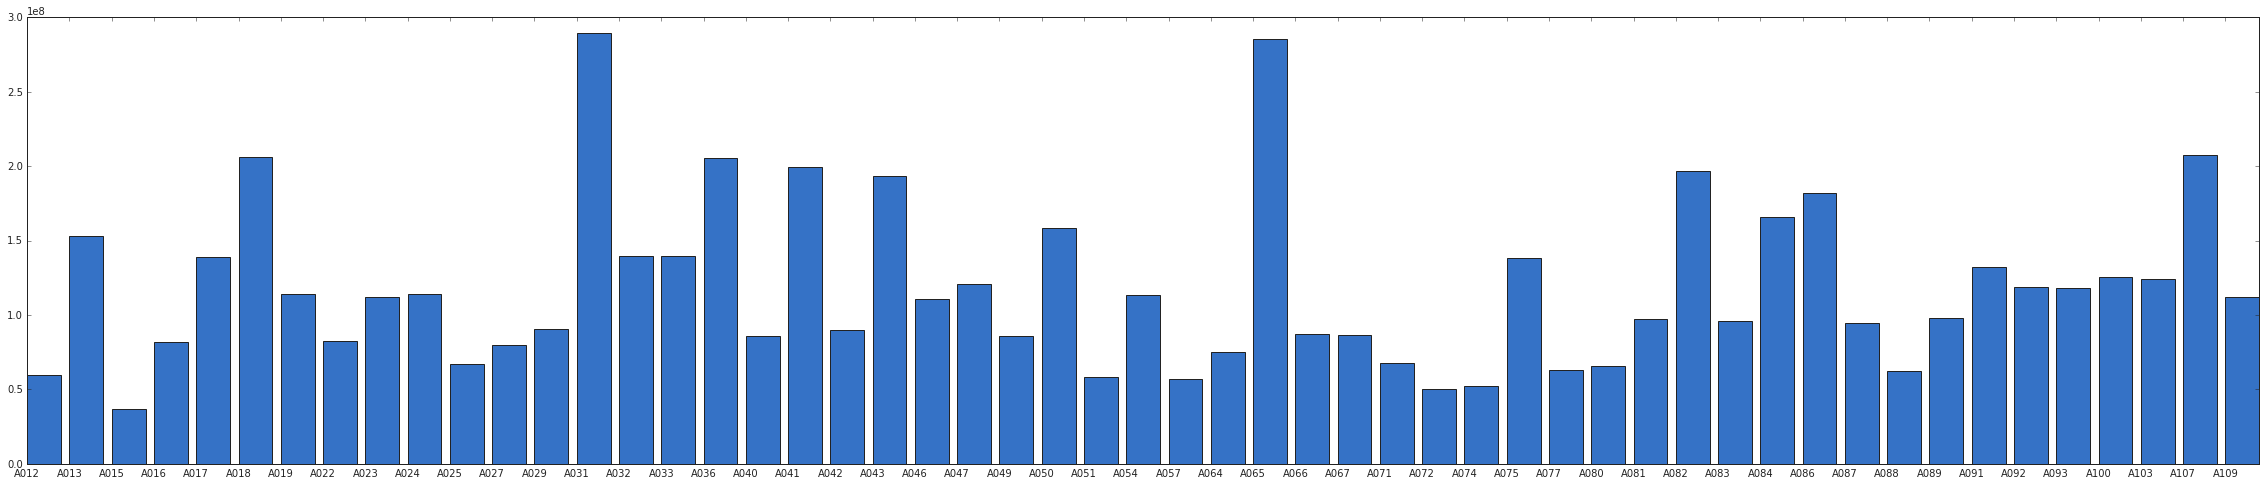

In [62]:
plt.figure(figsize=(40,8))
plt.bar(metadata.id,metadata.mask_volume)

<BarContainer object of 67 artists>

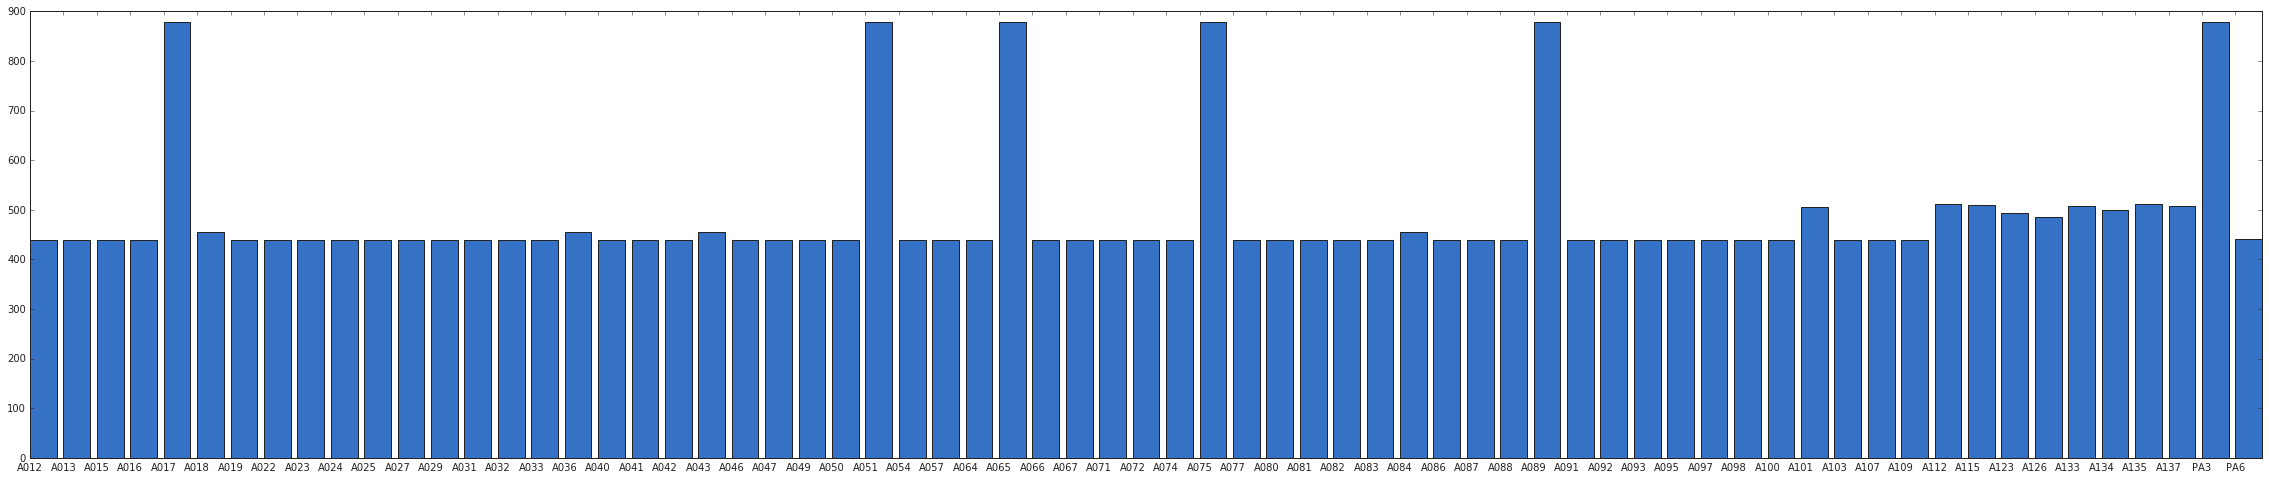

In [31]:
plt.figure(figsize=(40,8))
plt.bar(metadata.id,metadata.ct_layers)

<BarContainer object of 53 artists>

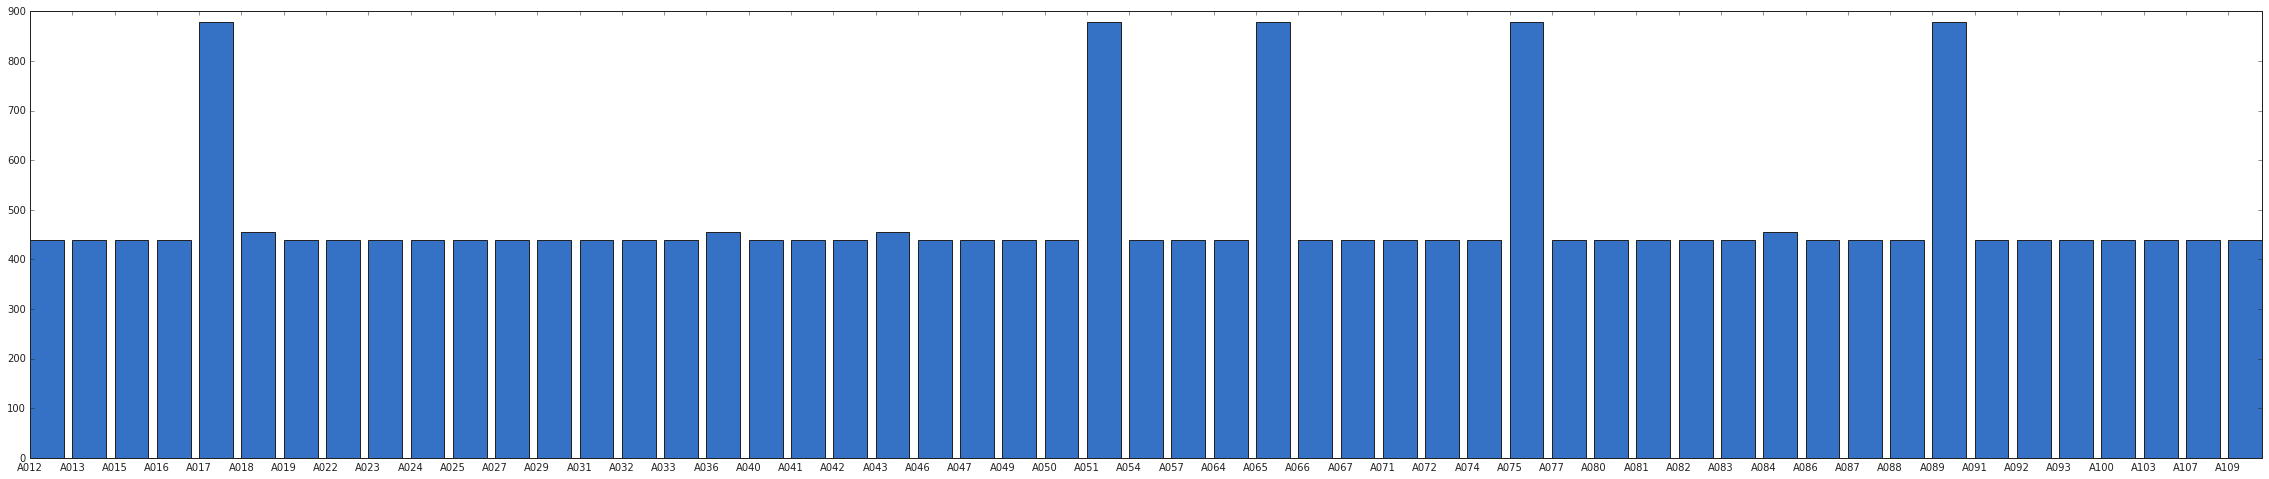

In [64]:
plt.figure(figsize=(40,8))
plt.bar(metadata.id,metadata.ct_layers)

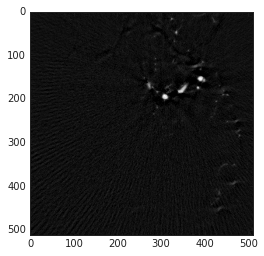

In [69]:
pixel_array = dcm.read_file(str(TRAIN_DCM/"A013.dcm")).pixel_array
Image.fromarray(pixel_array[180])
plt.imshow(pixel_array[180],cmap=pylab.cm.binary_r)

In [70]:
train_512 = np.array(sorted(list(TRAIN_512.iterdir())))
train_128 = np.array(sorted(list(TRAIN_128.iterdir())))
mask_512 = np.array(sorted(list(MASK_512.iterdir())))
mask_128 = np.array(sorted(list(MASK_128.iterdir())))

print(np.shape(mpimg.imread(str(train_512[88]))))
print(np.shape(mpimg.imread(str(train_128[88]))))
print(np.shape(mpimg.imread(str(mask_512[88]))))
print(np.shape(mpimg.imread(str(mask_128[88]))))

(512, 512)
(128, 128)
(512, 512)
(128, 128)


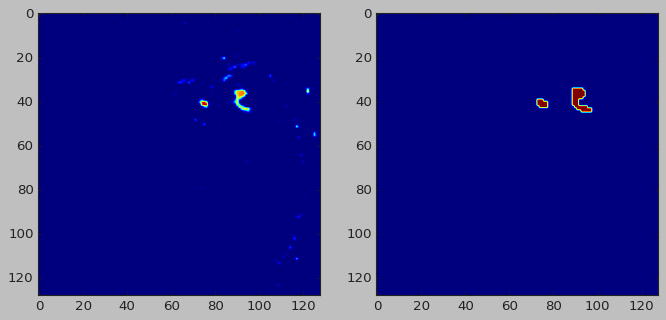

In [1054]:
idx = 95
f = plt.figure(figsize=(10,10))
f.add_subplot(1,2, 1)
plt.imshow(plt.imread(str(train_128[idx])))
f.add_subplot(1,2, 2)
plt.imshow(plt.imread(str(mask_128[idx])))

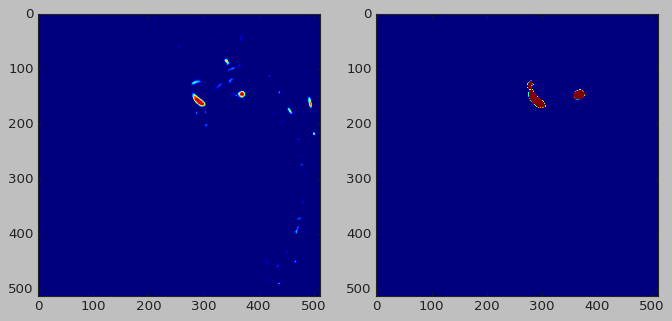

In [1055]:
idx = 88

f = plt.figure(figsize=(10,10))
f.add_subplot(1,2, 1)
plt.imshow(plt.imread(str(train_512[idx])))
f.add_subplot(1,2, 2)
plt.imshow(plt.imread(str(mask_512[idx])))

In [1056]:
img = plt.imread(str(train_512[idx]))
print(np.shape(img))
print(np.unique(img))

img = plt.imread(str(mask_512[idx]))
print(np.shape(img))
print(np.unique(img))

(512, 512)
[0.      0.00002 0.00003 ... 0.07117 0.07214 0.07242]
(512, 512)
[0. 1.]
